# Fire Detection Using Transfer Learning

## Importing Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from datetime import datetime

## Loading Dataset

In [3]:
BASE_DIR = "fire_dataset/"


FIRE_DIR = os.path.join(BASE_DIR, "fire_images")
NONFIRE_DIR = os.path.join(BASE_DIR, "non_fire_images")

print("🔥 Fire images:", len(os.listdir(FIRE_DIR)))
print("🌿 Non-fire images:", len(os.listdir(NONFIRE_DIR)))


🔥 Fire images: 756
🌿 Non-fire images: 244


## Data Preprocessing and Image Data Generator

In [4]:
IMG_SIZE = (224, 224)     # Required for EfficientNet/MobileNet
BATCH_SIZE = 32

In [5]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.20
)

train_gen = datagen.flow_from_directory(
    BASE_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    BASE_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False
)

Found 802 images belonging to 2 classes.
Found 199 images belonging to 2 classes.


In [6]:
idx_to_label = {v: k for k, v in train_gen.class_indices.items()}
idx_to_label

{0: 'fire_images', 1: 'non_fire_images'}

## Model Compilation and Class Weight Balancing

In [7]:
y_classes = train_gen.classes

weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_classes),
    y=y_classes
)

class_weights = {i: w for i, w in enumerate(weights)}
class_weights

{0: np.float64(0.6617161716171617), 1: np.float64(2.045918367346939)}

## Transfer Learning with EfficientNetB0

In [8]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(224,224,3),
    weights='imagenet'
)
base_model.trainable = False   # first stage

Implemented transfer learning using the EfficientNetB0 model to improve the accuracy of fire detection. Instead of training a model from scratch, I used the pretrained EfficientNetB0 weights (trained on ImageNet) and added custom layers on top for classification. The base model was frozen initially, and only the new layers were trained. This helps the model learn better features, reduced training time, and improved overall performance on the fire vs non-fire dataset.

## Model Architecture: Transfer Learning

In [29]:
inputs = layers.Input(shape=(*IMG_SIZE, 3))

x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


## Tensorboard Integration

In [10]:
log_dir = "logs/effnet_fire_" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='batch',       # 🔥 more frequent logging
    profile_batch=5            # 🔥 profile performance on batch 5
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [11]:
log_dir

'logs/effnet_fire_20251211-114646'

## Model Training

In [30]:
history = model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    class_weight=class_weights,
    callbacks=[tensorboard_callback, early_stop]
)

## Visualizations

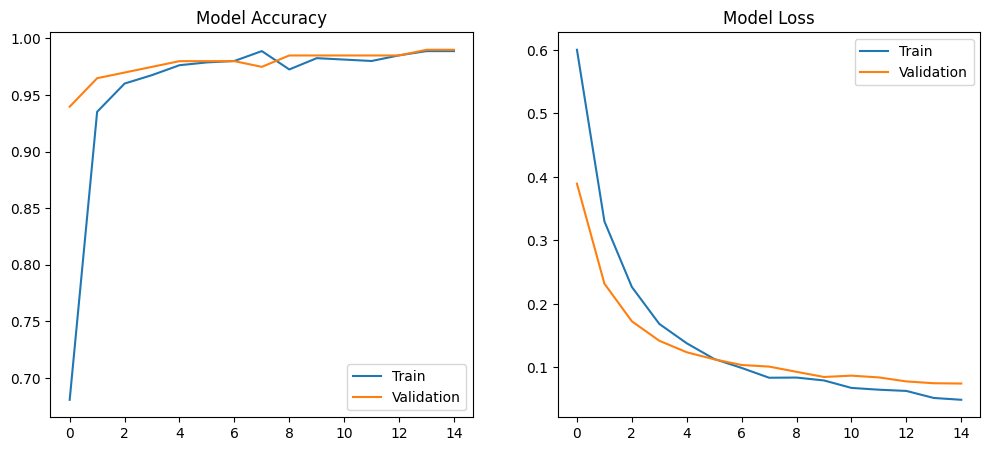

In [13]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.legend(["Train", "Validation"])

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.legend(["Train", "Validation"])

plt.show()


## Fine Tuning the Model

In [31]:
base_model.trainable = True

for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_finetune = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    class_weight=class_weights,
    callbacks=[tensorboard_callback]
)


## Visualizations after Fine Tuning

In [17]:
model

<Functional name=functional, built=True>

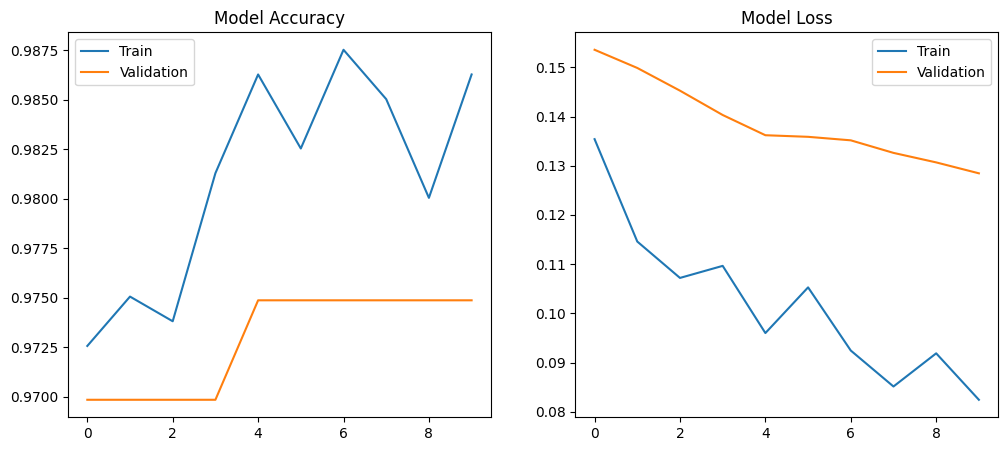

In [16]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history_finetune.history['accuracy'])
plt.plot(history_finetune.history['val_accuracy'])
plt.title("Model Accuracy")
plt.legend(["Train", "Validation"])

plt.subplot(1,2,2)
plt.plot(history_finetune.history['loss'])
plt.plot(history_finetune.history['val_loss'])
plt.title("Model Loss")
plt.legend(["Train", "Validation"])

plt.show()


Found 199 images belonging to 2 classes.
199/199 ━━━━━━━━━━━━━━━━━━━━ 23s 82ms/step


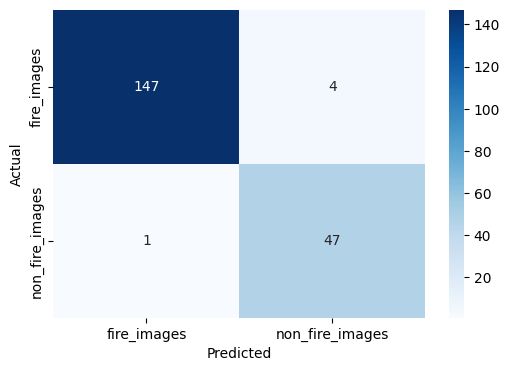

                 precision    recall  f1-score   support

    fire_images       0.99      0.97      0.98       151
non_fire_images       0.92      0.98      0.95        48

       accuracy                           0.97       199
      macro avg       0.96      0.98      0.97       199
   weighted avg       0.98      0.97      0.98       199



In [18]:
val_gen_cm = datagen.flow_from_directory(
    BASE_DIR,
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode="binary",
    subset="validation",
    shuffle=False
)

y_true = val_gen_cm.classes
y_pred_prob = model.predict(val_gen_cm)
y_pred = (y_pred_prob > 0.5).astype("int32")

cm = confusion_matrix(y_true, y_pred)

import seaborn as sns
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=idx_to_label.values(),
            yticklabels=idx_to_label.values())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_true, y_pred,
      target_names=list(idx_to_label.values())))


##### Confusion Matrix (EfficientNetB0 Transfer Learning)

The confusion matrix shows strong performance from the EfficientNetB0 transfer learning model. Out of 151 fire images, the model correctly predicted 147 and misclassified only 4. For non-fire images, it correctly predicted 47 out of 48, with just 1 incorrect prediction. These results indicate that the model is able to distinguish fire and non-fire images with high accuracy, achieving good precision, recall, and a 0.98 overall accuracy score.

## Performance Improvement Using another Pre-Trained model

## Transfer Learning with VGG16

In [19]:
import tensorflow as tf
from tensorflow import keras
keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    name="vgg16",
)

<Functional name=vgg16, built=True>

The VGG16 pretrained model for transfer learning to improve fire image classification. The pretrained layers were kept frozen, and new dense layers were added and trained on my dataset. This helps the model learn useful features quickly and improves the accuracy compared to training from scratch.

In [32]:
inputs = layers.Input(shape=(*IMG_SIZE, 3))

x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


In [21]:
log_dir = "logs/VGG16_fire_" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='batch',       # 🔥 more frequent logging
    profile_batch=5            # 🔥 profile performance on batch 5
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [22]:
log_dir

'logs/VGG16_fire_20251211-122656'

In [33]:
history = model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    class_weight=class_weights,
    callbacks=[tensorboard_callback, early_stop]
)

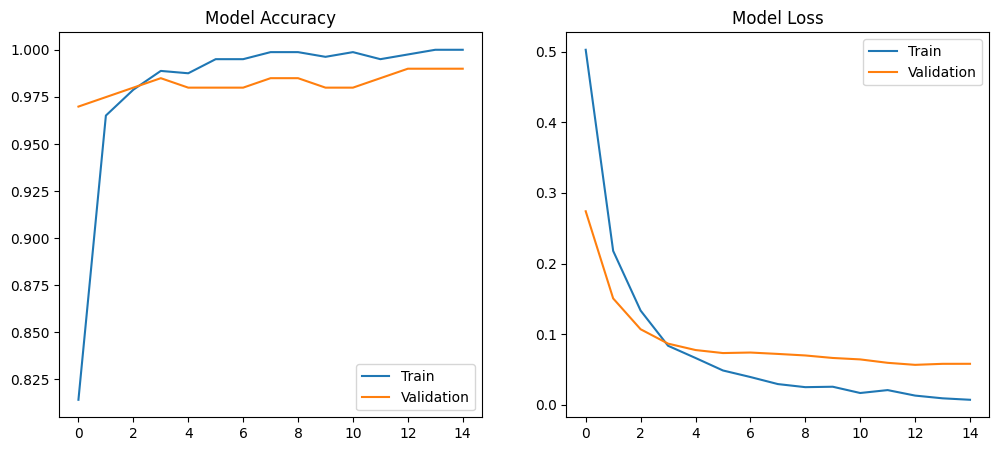

In [24]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.legend(["Train", "Validation"])

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.legend(["Train", "Validation"])

plt.show()

## Testing the Model

Found 199 images belonging to 2 classes.
199/199 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step


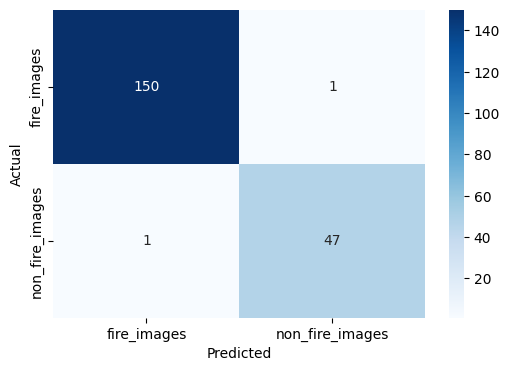

                 precision    recall  f1-score   support

    fire_images       0.99      0.99      0.99       151
non_fire_images       0.98      0.98      0.98        48

       accuracy                           0.99       199
      macro avg       0.99      0.99      0.99       199
   weighted avg       0.99      0.99      0.99       199



In [25]:
val_gen_cm = datagen.flow_from_directory(
    BASE_DIR,
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode="binary",
    subset="validation",
    shuffle=False
)

y_true = val_gen_cm.classes
y_pred_prob = model.predict(val_gen_cm)
y_pred = (y_pred_prob > 0.5).astype("int32")

cm = confusion_matrix(y_true, y_pred)

import seaborn as sns
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=idx_to_label.values(),
            yticklabels=idx_to_label.values())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_true, y_pred,
      target_names=list(idx_to_label.values())))

##### Confusion Matrix(VGG16 Transfer learning)
The confusion matrix shows that the transfer learning model performed highly accurately on the test dataset. Out of all fire images, the model correctly predicted almost all of them, with only 1 misclassification. Similarly, the model correctly identified most non-fire images with only 1 incorrect prediction. This indicates that the VGG16-based model has learned strong feature representations and is able to distinguish fire and non-fire images with high reliability.

In [26]:
from tensorflow.keras.preprocessing import image

def predict_image(path):
    img = image.load_img(path, target_size=IMG_SIZE)
    img_arr = image.img_to_array(img) / 255.0
    img_arr = np.expand_dims(img_arr, axis=0)

    prob = model.predict(img_arr)[0][0]
    pred_class = int(prob > 0.5)

    label = idx_to_label[pred_class]

    plt.imshow(img)
    plt.axis("off")

    if "fire" in label:
        plt.title(f"🔥 FIRE DETECTED (prob={prob:.2f})")
    else:
        plt.title(f"🌿 NON-FIRE (prob={prob:.2f})")

    plt.show()


## Saving Model

In [28]:
model.save("fire_detection_cnn") #path